In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pathlib
import ffmpeg
import numpy as np
from PIL import Image
import sys
import sys
sys.path.insert(0, "../controller")
import tile_configuration
from config import PIXEL_SCALE
from util import get_image_dimensions
import shapely


In [31]:
g = glob.glob("../controller/movie/*/tile_config.0.json")
s = sorted(g, key=lambda x: float(x.split("\\")[-2]))zz
d = pathlib.Path(s[-1])

In [32]:
prefix = d.parent
r = pd.read_json(f"{prefix}/tile_config.0.json", lines=True)
r.set_index(["sequence"])
tc = tile_configuration.TileConfiguration()
for row in r.itertuples():
    tc.addImage(filename=row.fname, x=row.x, y=row.y)
tc.move_to_origin()
tc.scale(1 / PIXEL_SCALE, 1 / PIXEL_SCALE)
tc.save(f"{prefix}/TileConfiguration.txt")

In [44]:
fname = d.parent / "test.0.mkv"
print(fname)
images_path = d.parent / "images"
images_path.mkdir(parents=True, exist_ok=True)

process = (
    ffmpeg.
    input(
        fname,)
    .output(
        "pipe:", format="rawvideo", pix_fmt="rgb24"
    )  
    .run_async(pipe_stdout=True)
    )

for item in r['sequence'].to_list():
    print(item)
    s = process.stdout.read(1280*720*3)
    if len(s) == 0:
        print("eof")
        break
    n = np.frombuffer(s, np.uint8).reshape(720, 1280, 3)
    i = Image.fromarray(n)
    fname = images_path / ("test.%05d.tif" % item)
    i.save(fname)

..\controller\movie\1736037197.3284676\test.0.mkv
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492


In [45]:
polys = []
box_to_fname = {}
for image in tc.images:
    filename = pathlib.Path(prefix) / image.filename
    width, height = 1280, 720 # get_image_dimensions(filename)

    b = shapely.geometry.box(
        int(image.x), int(image.y), int(image.x) + width, int(image.y) + height
    )
    box_to_fname[b] = filename
    polys.append(b)

c = shapely.geometry.GeometryCollection(polys)
tree = shapely.strtree.STRtree(polys)



In [46]:
tc.images

[TileImage(filename=WindowsPath('images/test.03303.tif'), x=0.0, y=0.0),
 TileImage(filename=WindowsPath('images/test.03304.tif'), x=0.0, y=0.0),
 TileImage(filename=WindowsPath('images/test.03305.tif'), x=0.0, y=0.0),
 TileImage(filename=WindowsPath('images/test.03306.tif'), x=0.0, y=0.0),
 TileImage(filename=WindowsPath('images/test.03307.tif'), x=0.0, y=0.0),
 TileImage(filename=WindowsPath('images/test.03308.tif'), x=0.0, y=0.0),
 TileImage(filename=WindowsPath('images/test.03309.tif'), x=0.0, y=0.0),
 TileImage(filename=WindowsPath('images/test.03310.tif'), x=0.0, y=0.0),
 TileImage(filename=WindowsPath('images/test.03311.tif'), x=0.0, y=0.0),
 TileImage(filename=WindowsPath('images/test.03312.tif'), x=0.0, y=0.0),
 TileImage(filename=WindowsPath('images/test.03313.tif'), x=0.0, y=0.0),
 TileImage(filename=WindowsPath('images/test.03314.tif'), x=0.0, y=0.8330000000000009),
 TileImage(filename=WindowsPath('images/test.03315.tif'), x=0.0, y=1.6660000000000017),
 TileImage(filename=W

In [47]:
df = pd.DataFrame(tc.images)
intersections = []
mid_x = 1280/2
points = []
keep_fnames = []
for y in np.arange(df["y"].min(), df["y"].max(), 720/2):
    p = shapely.geometry.point.Point(mid_x, y)
    overlapping_polygons = tree.query(p)
    middle_poly = overlapping_polygons[0]
    path = pathlib.Path(box_to_fname[polys[middle_poly]])
    fname = pathlib.Path(*path.parts[-2:]).with_suffix(".tif")
    keep_fnames.append(fname)
    #print()

new_images = []
for image in tc.images:
    image.filename = pathlib.Path(image.filename).with_suffix(".tif")
    if image.filename in keep_fnames:
        new_images.append(image)

new_tc = tile_configuration.TileConfiguration()
new_tc.images = new_images
new_tc.save(prefix / "TileConfiguration.sampled.txt")     
c2 = shapely.geometry.GeometryCollection(points)


In [37]:
df = pd.read_json(d, lines=True, orient='records')
df.index = df["sequence"]
df["timestamp"] = pd.to_datetime(df['tv_sec'], unit='s') + pd.to_timedelta(df['tv_nsec'], unit='ns')
df.drop("tv_sec", axis=1, inplace=True)
df.drop("tv_nsec", axis=1, inplace=True)

df['timestamp_shift'] = df['timestamp'].shift()
df['timestamp_delta'] = df['timestamp'] - df['timestamp_shift']


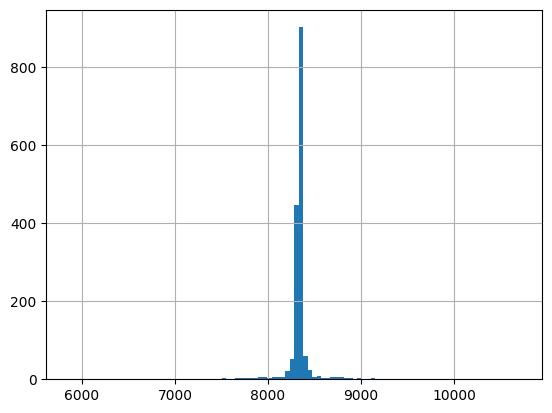

In [38]:
%matplotlib inline
#df.plot(y="timestamp_delta")
df['timestamp_delta'].dt.microseconds.hist(bins=100)
plt.show()